# Benchmark com Microsoft GrabCut (50 imagens)

Utilizando a métrica _error rate_, esse notebook propõe-se construir uma avaliação no dataset grabcut para avaliar a taxa de erro médio para o algoritmo EGSIS. A intenção é realizar uma comparação com as técnicas avaliadas no artigo _Segmentation by transduction_

O. Duchenne, J. -Y. Audibert, R. Keriven, J. Ponce and F. Segonne, "Segmentation by transduction," 2008 IEEE Conference on Computer Vision and Pattern Recognition, Anchorage, AK, USA, 2008, pp. 1-8, doi: 10.1109/CVPR.2008.4587419.

In [1]:
import os
os.environ["LOGURU_LEVEL"] = "ERROR"

In [2]:
from egsis.datasets import grabcut
import matplotlib.pyplot as plt
from egsis import model
from egsis import metrics
from egsis import image

# Avaliação única aleatória

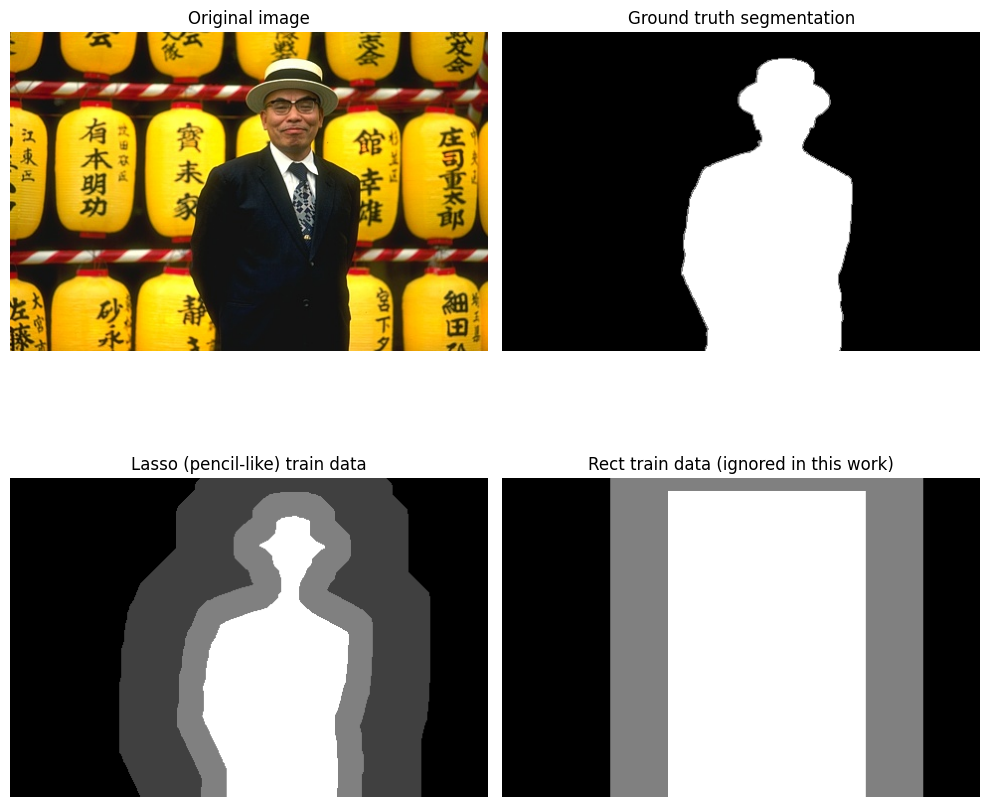

In [23]:
img = grabcut.get_random_image()
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

ax[0, 0].imshow(img.data)
ax[0, 0].set_title("Original image")
ax[0, 1].imshow(img.segmentation, cmap="gray")
ax[0, 1].set_title("Ground truth segmentation")
ax[1, 0].imshow(img.lasso, cmap="gray")
ax[1, 0].set_title("Lasso (pencil-like) train data")
ax[1, 1].imshow(img.rect, cmap="gray")
ax[1, 1].set_title("Rect train data (ignored in this work)")


for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()

# Labelling description 

**Segmentation**: A tri-map which specifies background (0), foreground (255) and
mixed area (128). The mixed area contains pixels which are a combination of foreand background texture. Note, in low contrast regions the true boundary is not
observed and the ground truth is in this case a "good guess".

**Labelling-Lasso**: Imitates a tri-map obtained by a lasso or pen tool. The colour
coding is: 

- background (0);
- background - used for colour model training (64);
- inference (unknown) region (128);
- foreground - used for colour model training (255).

Note, a lasso tool can be imitated by specifying the foreground region (255) as unknown
(128).

**Labelling-Rectangle**: Imitates a tri-map obtained by two mouse clicks (rectangle).
Same colour coding as in Labelling-Lasso.

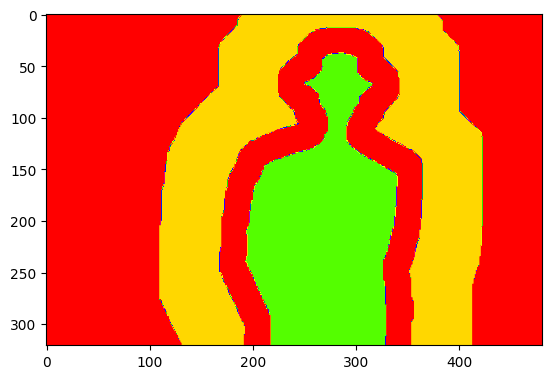

In [25]:
# Preprocessing labeling scheme
# y_train = img.lasso
# y_train[y_train == 64] = 1 # background
# y_train[y_train == 128] = 0 # means unlabelled for egsis
# y_train[y_train == 255] = 2 # foreground
# y_true = img.segmentation
# y_true[y_true == 128] = 1
# y_true[y_true == 255] = 1

# not more necessary the steps above, replaced by:
y_train = img.y_train()
y_true = img.y_true()

# the green region it's training data for background
# the yellow region it's training data for foreground
plt.imshow(y_train, cmap="prism")  

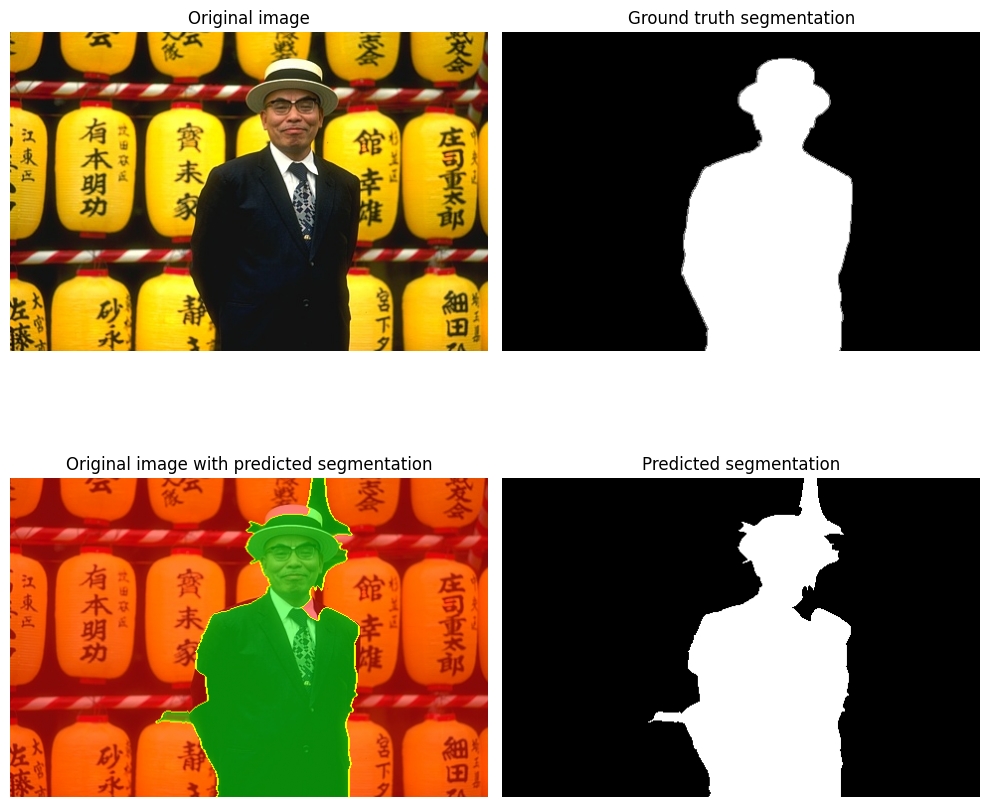

CPU times: user 28.3 s, sys: 15.7 s, total: 44.1 s
Wall time: 17.1 s


In [26]:
%%time

X = img.data
y = y_train

m = model.EGSIS(
    superpixel_segments=200,
    superpixel_sigma=0.8,
    superpixel_compactness=40,
    feature_extraction="comatrix",
    lcu_max_iter=100,
    feature_similarity="euclidian_exp",
)

# Fit predict receiving a image mask
# re-encoding y-values to be in {0,1} because for EGSIS, y=0 means non-labeled
mask = m.fit_predict_segmentation_mask(X, y) - 1

fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
labels_by_color = {
    0: "#ff0000", # background red
    1: "#00ff00" # foreground green
}
ax[0, 0].imshow(img.data)
ax[0, 0].set_title("Original image")
ax[0, 1].imshow(img.segmentation, cmap="gray")
ax[0, 1].set_title("Ground truth segmentation")
ax[1, 0].imshow(image.segmentation_mask_blend(img.data, mask, labels_by_color))
ax[1, 0].set_title("Original image with predicted segmentation")
ax[1, 1].imshow(mask, cmap="gray")
ax[1, 1].set_title("Predicted segmentation")


for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()

In [6]:
y_pred = mask
err = metrics.err(y_true, y_pred) * 100
iou = metrics.iou(y_true, y_pred)
f1 = metrics.f1(y_true, y_pred)
rc = metrics.recall(y_true, y_pred)
pr = metrics.precision(y_true, y_pred)
acc = metrics.pixel_accuracy(y_true, y_pred)
print("Segmentation Metrics!")
print(f"Err:\t{round(err, 2)}%") 
print(f"IoU:\t{round(iou, 2)}") 
print(f"F1:\t{round(f1, 2)}") 
print(f"Recall:\t{round(rc, 2)}") 
print(f"Precision:\t{round(pr, 2)}") 
print(f"acc:\t{round(acc, 2)}") 

Segmentation Metrics!
Err:	5.25%
IoU:	0.72
F1:	0.83
Recall:	0.78
Precision:	0.9
acc:	0.95


# Avaliação em Lote

In [7]:
%%time
import pandas as pd
imgs = grabcut.get_all_dataset()
stats = []
for img in imgs:
    X = img.data
    y_true = img.y_true()
    y_train = img.y_train()
    mask = m.fit_predict_segmentation_mask(X, y_train)
    # label re-encoding
    y_pred = mask - 1
    err = metrics.err(y_true, y_pred) * 100
    iou = metrics.iou(y_true, y_pred)
    f1 = metrics.f1(y_true, y_pred)
    acc = metrics.pixel_accuracy(y_true, y_pred)
    rc = metrics.recall(y_true, y_pred)
    pr = metrics.precision(y_true, y_pred)
    stat = [img.fname, err, iou, f1, rc, pr, acc]
    stats.append(stat)

df = pd.DataFrame(stats, columns=["name", "err", "iou", "f1", "recall", "precision", "acc"])
df.sort_values(by="err")

CPU times: user 4min 6s, sys: 842 ms, total: 4min 6s
Wall time: 4min 7s


,name,err,iou,f1,recall,precision,acc
25,grave.jpg,0.787778,0.938825,0.968447,0.971662,0.965254,0.992122
15,stone2.JPG,1.246745,0.951190,0.974985,0.981782,0.968281,0.987533
1,person1.jpg,1.602593,0.946890,0.972721,0.986963,0.958883,0.983974
10,person7.jpg,1.691111,0.764578,0.866585,0.767308,0.995369,0.983089
41,86016.jpg,1.727968,0.896199,0.945258,0.907104,0.986763,0.982720
48,fullmoon.bmp,1.758888,0.720952,0.837852,0.720952,1.000000,0.982411
21,208001.jpg,1.771362,0.871554,0.931369,0.936989,0.925817,0.982286
3,sheep.jpg,1.981852,0.680289,0.809729,0.765909,0.858867,0.980181
32,flower.jpg,2.289630,0.885593,0.939326,0.885691,0.999875,0.977104
4,person3.jpg,2.369259,0.782282,0.877843,0.845659,0.912574,0.976307


In [8]:
df.describe().round(4)

,err,iou,f1,recall,precision,acc
count,50.0000,50.0000,50.0000,50.0000,50.0000,50.0000
mean,4.8696,0.7412,0.8414,0.7882,0.9225,0.9513
std,2.6538,0.1557,0.1147,0.1573,0.0724,0.0265
min,0.7878,0.3223,0.4875,0.3223,0.7316,0.8756
25%,3.0343,0.6648,0.7986,0.7168,0.9024,0.9395
50%,4.5271,0.7677,0.8686,0.8407,0.9431,0.9547
75%,6.0455,0.8601,0.9248,0.9061,0.9734,0.9697
max,12.4384,0.9512,0.9750,0.9897,1.0000,0.9921
